<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/Copy_of_IoT_Security_Use_Case1_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7: IoT Security  

# Use Case 1: Intelligent Host Intrusion Detection in IoT

# Model: LSTM

# Step 1: Dataset

The dataset (.CSV file) on CPU utilisation of a computing system (say Raspberry Pi 3) is available in the chapter's use-case-1 folder.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving cpu-utilisation.csv to cpu-utilisation.csv


# Step 2: Dataset Exploration

In [13]:
import pandas as pd
import plotly.express as px 

df =pd.read_csv('cpu-utilisation.csv')
print(df.head(10))
fig = px.line(df, x = df['time'], y = df['cpu utilisation (%)'])
fig.show()


               time  cpu utilisation (%)
0  05/04/2019 19:42                 44.8
1  05/04/2019 19:43                 44.0
2  05/04/2019 19:44                 43.6
3  05/04/2019 19:45                 43.2
4  05/04/2019 19:46                 44.0
5  05/04/2019 19:47                 43.2
6  05/04/2019 19:48                 45.2
7  05/04/2019 19:49                 44.8
8  05/04/2019 19:50                 43.6
9  05/04/2019 19:51                 42.4


# Step 3: Pre-processing

The dataset we got are pre-processed as we can see from the data exploration above. Lets move to next step.

# Step 4: Model Training and Validation 

In [14]:
#Imort necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint


epochs = 100
batch_size = 50

# Each training data point will be length 100-1,
# since the last value in each sequence is the label
sequence_length = 100

# OMP error issue fixing (some machine may show error)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Input data generation
    
def prepare_data(data, train_start, train_end, test_start, test_end):
    print("Length of Data", len(data))

    # training data
    print("Preparaing training data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Training data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Test data shape  : {}".format(result.shape))

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test



# Generate the Model

In [15]:
# Model genration function

def generate_model():

    model = Sequential()

    # First LSTM layer defining the input sequence length
    model.add(LSTM(input_shape=(sequence_length-1, 1),
                   units=32,
                   return_sequences=True))
    model.add(Dropout(0.2))

    # Second LSTM layer with 128 units
    model.add(LSTM(units=128,
                   return_sequences=True))
    model.add(Dropout(0.2))

    # Third LSTM layer with 100 units
    model.add(LSTM(units=100,
                   return_sequences=False))
    model.add(Dropout(0.2))

    # Densely-connected output layer with the linear activation function
    model.add(Dense(units=1))
    model.add(Activation('linear'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    
    return model

# Run the Model

In [18]:
# Function for result normalisation
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean



## Function for running the model

def run_model(model=None, data=None):
    #global_start_time = time.time()

    print('Loading data... ')
    data_b = pd.read_csv('cpu-utilisation.csv',
                         parse_dates=[0], infer_datetime_format=True)
    data = data_b['cpu utilisation (%)'].to_numpy()

    # train on first 700 samples and test on next 300 samples (test set has anomaly)
    X_train, y_train, X_test, y_test = prepare_data(data, 0, 600, 400, 700)
    
    # tensor board setting 
    tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

    if model is None:
        model = generate_model()

    try:
        print("Training...")
        checkpointer = ModelCheckpoint(filepath="checkpoint-02.hdf5", 
                                         verbose=1, save_best_only=True, monitor='loss')
        model.fit(
                X_train, y_train,
                batch_size=batch_size, epochs=epochs, callbacks=[checkpointer, tensorboard],validation_split=0.05)
        print("Predicting...")
        
        predicted = model.predict(X_test)
        #model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1, callbacks=[checkpointer, tensorboard])

        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("Prediction exception")
        #print('Training duration:{}'.format(time.time() - global_start_time))
        return model, y_test, 0

    try:
        plt.figure(figsize=(20,8))
        plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        plt.plot(((y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    #print('Training duration:{}'.format(time.time() - global_start_time))

    return model, y_test, predicted

Loading data... 
Length of Data 700
Preparaing training data...
Training data shape  :  (500, 100)
Creating test data...
Test data shape  : (200, 100)
Shape X_train (500, 99)
Shape X_test (200, 99)
Training...
Epoch 1/100
10/10 [==============================] - 9s 481ms/step - loss: 0.5843 - val_loss: 0.2363

Epoch 00001: loss improved from inf to 0.45187, saving model to checkpoint-02.hdf5
Epoch 2/100
10/10 [==============================] - 3s 298ms/step - loss: 0.2227 - val_loss: 0.2166

Epoch 00002: loss improved from 0.45187 to 0.22436, saving model to checkpoint-02.hdf5
Epoch 3/100
10/10 [==============================] - 3s 299ms/step - loss: 0.1980 - val_loss: 0.1992

Epoch 00003: loss improved from 0.22436 to 0.22234, saving model to checkpoint-02.hdf5
Epoch 4/100
10/10 [==============================] - 3s 321ms/step - loss: 0.1684 - val_loss: 0.2358

Epoch 00004: loss improved from 0.22234 to 0.17682, saving model to checkpoint-02.hdf5
Epoch 5/100
10/10 [===================

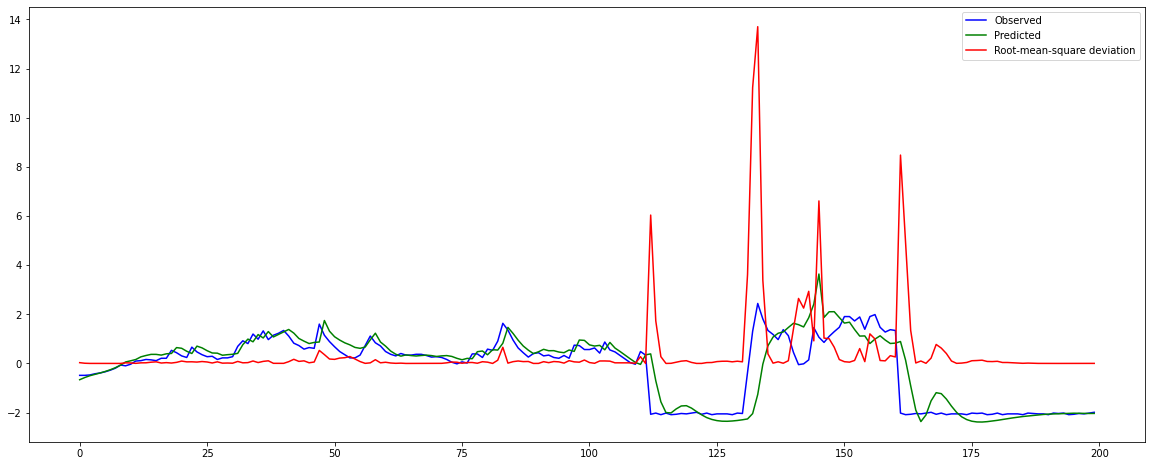

In [19]:
# Call the run function
    
model, y_test, predicted = run_model()